In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from utils.experiments import get_bh_integral_from_two_mats, get_stratified_fold_indices, get_waveform_est, BSAT_MAP
from utils.metrics import calculate_metrics
from run_cnn import main, construct_tensor_seq2seq, B_COLS, H_COLS, SUBSAMPLE_FACTOR


plt.style.use("default")
plt.rcParams.update({
    'figure.dpi': 200,  # renders images larger for notebook
    'axes.grid': True,
    'grid.alpha': 0.3,

})

DATA_SOURCE = Path.cwd().parent / 'data' / 'input' / 'raw'
PROC_SOURCE = DATA_SOURCE.parent/ "processed"

In [2]:
# Load data and Feature Engineering
materials = ["3f4"]
ds = pd.concat(
    [
        pd.read_pickle(PROC_SOURCE / f"{m.upper()}.pkl.gz").assign(material=m.upper())
        for m in materials
    ],
    ignore_index=True,
)
waveforms = get_waveform_est(ds.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy())
ds = pd.concat(
    [
        ds,
        pd.get_dummies(waveforms, prefix="wav", dtype=float).rename(
            columns={
                "wav_0": "wav_other",
                "wav_1": "wav_square",
                "wav_2": "wav_triangular",
                "wav_3": "wav_sine",
            }
        ),
    ],
    axis=1,
)

full_b = ds.loc[:, B_COLS].to_numpy()
dbdt = full_b[:, 1:] - full_b[:, :-1]
b_peak2peak = full_b.max(axis=1) - full_b.min(axis=1)
ds = ds.assign(
    b_peak2peak=b_peak2peak,
    log_peak2peak=np.log(b_peak2peak),
    mean_abs_dbdt=np.mean(np.abs(dbdt), axis=1),
    log_mean_abs_dbdt=np.log(np.mean(np.abs(dbdt), axis=1)),
    db_bsat=b_peak2peak / ds.material.map(BSAT_MAP),
)

## Experiment with limit normalization

In [3]:
log = main(ds=ds)

Train for 3F4
Parallelize over 1 seeds with 1 processes..


Seed 0, fold 0:   0%|          | 0/2000 [00:00<?, ?epoch/s]/home/wk/dev/tools/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
Seed 0, fold 0:   0%|          | 0/2000 [00:00<?, ?epoch/s]

Layer (type:depth-idx)                   Output Shape              Param #
TCNWithScalarsAsBias                     [1, 1, 128]               --
├─TemporalBlock: 1-1                     [1, 14, 128]              --
│    └─Sequential: 2-1                   [1, 14, 128]              --
│    │    └─Conv1d: 3-1                  [1, 14, 128]              126
│    │    └─Tanh: 3-2                    [1, 14, 128]              --
│    │    └─Dropout1d: 3-3               [1, 14, 128]              --
├─TemporalBlock: 1-2                     [1, 12, 128]              --
│    └─Sequential: 2-2                   [1, 12, 128]              --
│    │    └─Conv1d: 3-4                  [1, 12, 128]              96
│    │    └─Tanh: 3-5                    [1, 12, 128]              --
│    │    └─Dropout1d: 3-6               [1, 12, 128]              --
├─Sequential: 1-3                        [1, 1, 128]               --
│    └─TemporalBlock: 2-3                [1, 12, 128]              --
│    │    └─Se

Seed 0, fold 1: 100%|██████████| 2000/2000 [01:53<00:00, 17.57epoch/s, Loss 2.27e-05| val loss 2.62e-05]

































































































































































































































































































































































































































































































































































































































































































































































































































































































































Overall Score
            0
3F4  0.206315


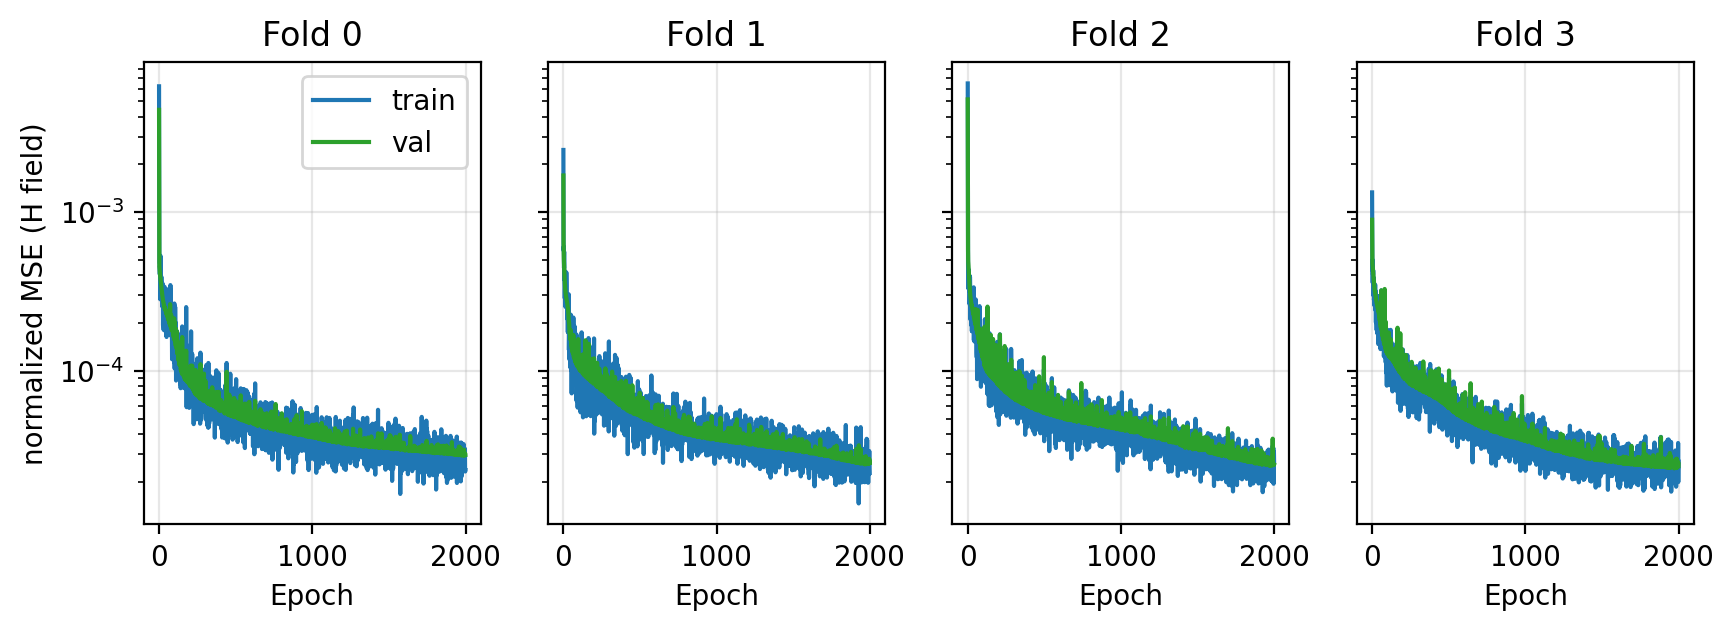

In [4]:
fig, axes = plt.subplots(1, len(log['3F4'][0]['loss_trends_train']), sharey=True, sharex=True, figsize=(10,3))
for n, (fold, ax) in enumerate(zip(log['3F4'][0]['loss_trends_train'] , axes)):
    ax.plot(fold, label='train' if ax is axes[0] else None, color='tab:blue')
    ax.set_title(f'Fold {n}')
    if n == 0:
        ax.set_ylabel('normalized MSE (H field)')
    ax.set_xlabel('Epoch')
    
for fold, ax in zip(log['3F4'][0]['loss_trends_val'], axes):
    ax.plot(fold, label='val' if ax is axes[0] else None, color='tab:green')
    ax.set_yscale('log')
axes[0].legend()


In [5]:
mat_df = ds
mat_df_proc = mat_df.assign(kfold=get_stratified_fold_indices(mat_df, 4))
mat_df_proc.drop(columns=["material"]).groupby('kfold').mean()

ploss      H_t_0      H_t_1      H_t_2      H_t_3      H_t_4  \
kfold                                                                         
0      234450.431189 -52.509797 -52.612627 -52.259090 -51.851729 -51.473718   
1      235442.150593 -52.375362 -52.456504 -52.099208 -51.650140 -51.223742   
2      239843.880792 -51.575139 -51.667113 -51.302248 -50.869942 -50.493127   
3      237585.406532 -52.855536 -52.956625 -52.589507 -52.170015 -51.786644   

           H_t_5      H_t_6      H_t_7      H_t_8      H_t_9     H_t_10  \
kfold                                                                     
0     -51.030404 -50.564112 -50.161126 -49.783917 -49.376153 -48.946204   
1     -50.773821 -50.328991 -49.917216 -49.519375 -49.110416 -48.661743   
2     -50.064976 -49.608625 -49.171400 -48.753727 -48.319359 -47.868341   
3     -51.378794 -50.934596 -50.510561 -50.091241 -49.657594 -49.198948   

          H_t_11     H_t_12     H_t_13     H_t_14     H_t_15     H_t_16  \
kfold                                                                     
0     -48.524708 -48.090871 -47.620312 -47.159422 -46.699824 -46.238758   
1     -48.215246 -47.762516 -47.286389 -46.823621 -46.356014 -45.879893   
2     -47.416216 -46.972997 -46.510599 -46.050663 -45.592339 -45.133215   
3     -48.733593 -48.281710 -47.811843 -47.352924 -46.898430 -46.441937   

          H_t_17     H_t_18     H_t_19     H_t_20     H_t_21     H_t_22  \
kfold                                                                     
0     -45.796980 -45.378347 -44.953262 -44.523299 -44.097225 -43.695129   
1     -45.433075 -45.003451 -44.575393 -44.138678 -43.706736 -43.302820   
2     -44.692332 -44.273386 -43.848745 -43.414999 -42.975015 -42.563534   
3     -46.004296 -45.579600 -45.156449 -44.721013 -44.288348 -43.880409   

          H_t_23     H_t_24     H_t_25     H_t_26     H_t_27     H_t_28  \
kfold                                                                     
0     -43.303310 -42.917360 -42.520569 -42.115334 -41.710267 -41.316695   
1     -42.910011 -42.509950 -42.093878 -41.677414 -41.262141 -40.857200   
2     -42.164173 -41.760937 -41.349545 -40.931891 -40.520272 -40.119083   
3     -43.489662 -43.090944 -42.683159 -42.269944 -41.847768 -41.453947   

          H_t_29     H_t_30     H_t_31     H_t_32     H_t_33     H_t_34  \
kfold                                                                     
0     -40.923008 -40.518757 -40.109608 -39.698215 -39.292458 -38.888286   
1     -40.454281 -40.040285 -39.619780 -39.201803 -38.786477 -38.373139   
2     -39.713689 -39.298098 -38.884277 -38.460085 -38.051118 -37.637088   
3     -41.059179 -40.652420 -40.240907 -39.820336 -39.394443 -38.985897   

          H_t_35     H_t_36     H_t_37     H_t_38     H_t_39     H_t_40  \
kfold                                                                     
0     -38.490925 -38.106614 -37.715574 -37.318008 -36.917557 -36.512307   
1     -37.970688 -37.570020 -37.169977 -36.764605 -36.356260 -35.934654   
2     -37.235036 -36.836425 -36.445102 -36.037633 -35.630135 -35.216580   
3     -38.581231 -38.183508 -37.782693 -37.384568 -36.974066 -36.565941   

          H_t_41     H_t_42     H_t_43     H_t_44     H_t_45     H_t_46  \
kfold                                                                     
0     -36.106208 -35.700763 -35.303644 -34.918611 -34.536983 -34.151392   
1     -35.525456 -35.109924 -34.706640 -34.309528 -33.911176 -33.517851   
2     -34.801075 -34.389998 -33.988013 -33.592397 -33.201427 -32.811435   
3     -36.150355 -35.742026 -35.348915 -34.949389 -34.563348 -34.176841   

          H_t_47     H_t_48     H_t_49     H_t_50     H_t_51     H_t_52  \
kfold                                                                     
0     -33.773810 -33.380564 -32.991943 -32.600911 -32.202987 -31.818884   
1     -33.129589 -32.727788 -32.331405 -31.933103 -31.536949 -31.145001   
2     -32.424854 -32.026750 -31.625585 -31.227351 -30.824946 -30.430426   
3     -3

In [6]:
device = torch.device("cuda")
x_cols = [c for c in mat_df_proc if c not in ["ploss", "kfold"] and not c.startswith(("B_t_", "H_t_", "material"))]
b_limit = np.abs(mat_df_proc.loc[:, B_COLS].to_numpy()).max()
h_limit = np.abs(mat_df_proc.loc[:, H_COLS].to_numpy()).max()
full_set = construct_tensor_seq2seq(mat_df_proc, x_cols, b_limit, h_limit).to(device)

mdl = log['3F4'][0]['models_state_dict'][0].to(device)
with torch.inference_mode():
    g_truth = full_set[:, :, [-1]]
    X_tensor = full_set[:, :, :-1]
    output = mdl(X_tensor.permute(1, 2, 0)).permute(2, 0, 1)

In [7]:
h_pred = output.squeeze().cpu().numpy().T * h_limit
p_pred = get_bh_integral_from_two_mats(
    freq=mat_df_proc.freq, #np.exp(full_set.cpu().numpy()[0, :, [0]]) * 150_000,
    b=mat_df_proc.loc[:, B_COLS],#full_set.cpu().numpy()[:, :, -2].T * b_limit,
    h=h_pred,
)
calculate_metrics(p_pred, mat_df_proc.loc[:, 'ploss'])

{'mse': 1636951359.0323262,
 'mae': 17712.982980289522,
 'avg-abs-rel-err': 0.24798266297479687,
 'percentile_5_rel_err': 0.009281273136519625,
 'percentile_95_rel_err': 0.944561404029107,
 'l_infty': 794892.4342868407,
 'l_infty_over': 451205.77377569117,
 'l_infty_under': -794892.4342868407}

In [10]:
p_derived = get_bh_integral_from_two_mats(freq=mat_df_proc.freq, b=mat_df_proc.loc[:, B_COLS], h=mat_df_proc.loc[:, H_COLS])
calculate_metrics(p_derived, mat_df_proc.loc[:, 'ploss'])

{'mse': 38992979.205653675,
 'mae': 3913.3350232703256,
 'avg-abs-rel-err': 0.042169654629524,
 'percentile_5_rel_err': 0.007061112434444114,
 'percentile_95_rel_err': 0.10347815880963578,
 'l_infty': 42410.45597695047,
 'l_infty_over': 9931.942968738018,
 'l_infty_under': -42410.45597695047}

/tmp/ipykernel_35742/2608091353.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


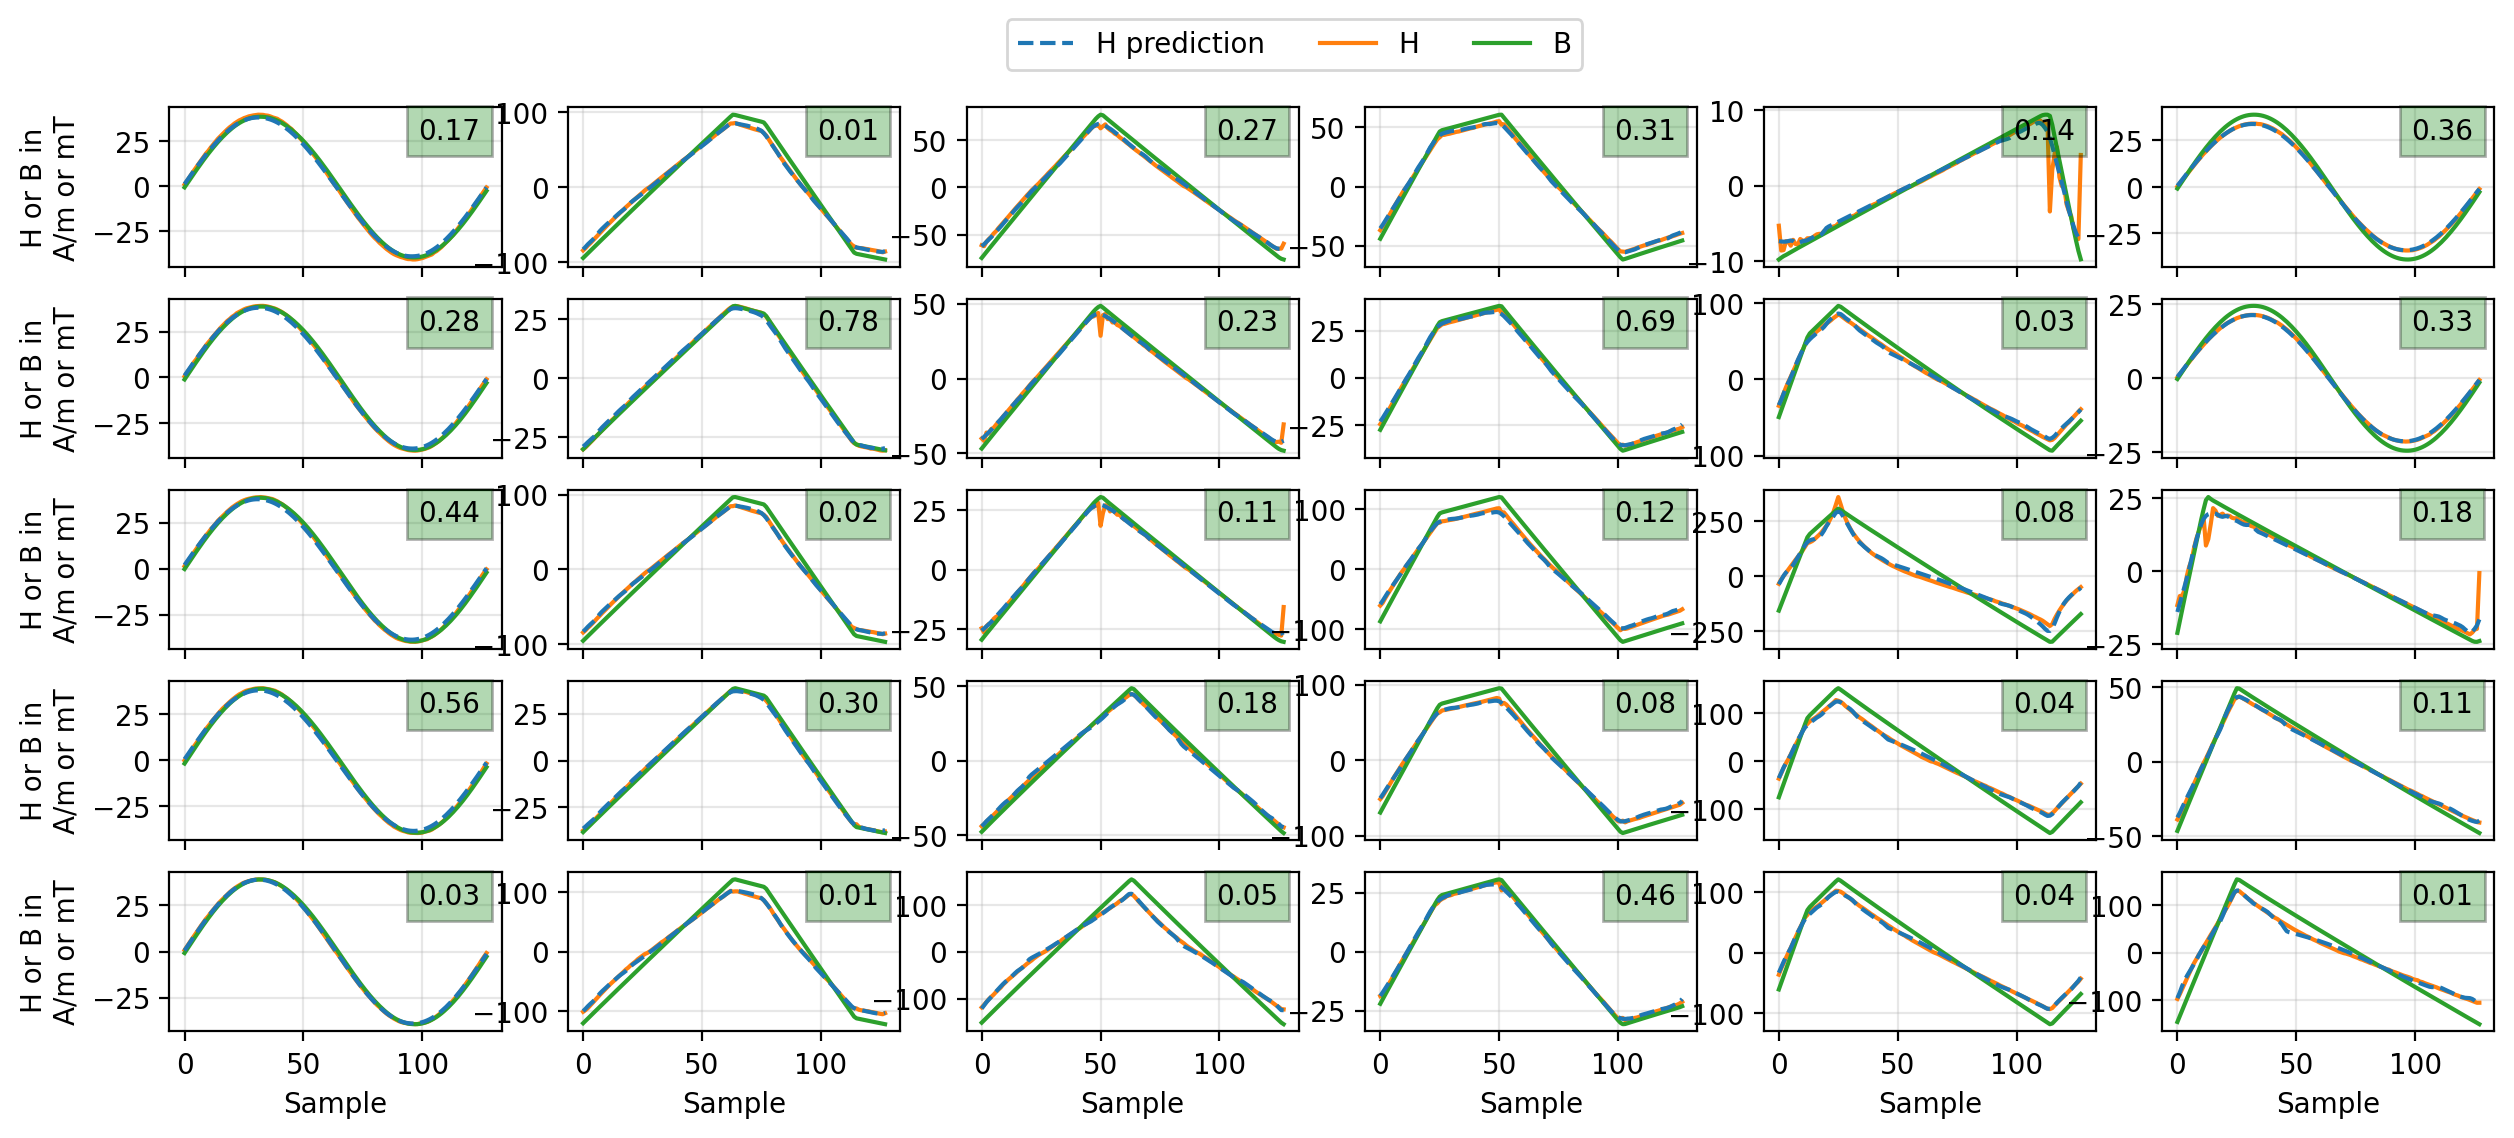

In [9]:
tois = np.arange(0, 6000, 1000)  # trajectory of interest
n_sub_trajs = 5
full_h = mat_df_proc.loc[:, [c for c in mat_df_proc if c.startswith("H_t_")][::SUBSAMPLE_FACTOR], ]
fig, axes = plt.subplots(n_sub_trajs,len(tois), figsize=(15, 6), sharex=True, sharey=False)
for i, toi in enumerate(tois):
    for j in range(n_sub_trajs):  # subvariations
        t_ind = toi + j * 5
        h = full_h.loc[t_ind, :].to_numpy()  # in A/m
        p = mat_df_proc.loc[t_ind, 'ploss']
        ax = axes[j, i]
        if i == 0:
            ax.set_ylabel("H or B in\nA/m or mT")
        if j == n_sub_trajs-1:
            ax.set_xlabel("Sample")
        ln2 = ax.plot(h, color="tab:orange", label="H", )
        ln3 = ax.plot(mat_df_proc.loc[t_ind, [c for c in mat_df_proc if c.startswith("B_t_")][::SUBSAMPLE_FACTOR], ].to_numpy()* 1000, color="tab:green", label="B")
        ax.text(0.75, 0.8, f"{np.abs(p_pred[t_ind]-p)/ p:.2f}", transform=ax.transAxes, bbox=dict(facecolor='green', alpha=0.3))
        ln1 = ax.plot(h_pred[t_ind], color="tab:blue", label="H prediction", ls='dashed')
        lns = ln1 + ln2 + ln3
        legend_labels = [l.get_label() for l in lns]
        if i == 0 and j == 0:
            ax.legend(lns,legend_labels,ncol=3,frameon=True,markerscale=0.5,loc="lower center",bbox_to_anchor=(0.5, 0.9),bbox_transform=fig.transFigure,)
fig.tight_layout()

      rel_err_pred  rel_err_gtruth
3971      2.569397        0.025744
2361      2.440500        0.630326
626       2.257798        0.454423
1099      2.192992        0.105718
3903      2.112156        0.094727
...            ...             ...
2284      0.000052        0.016002
5375      0.000044        0.006192
1622      0.000028        0.010769
5268      0.000023        0.061316
6384      0.000011        0.075405

[6563 rows x 2 columns]


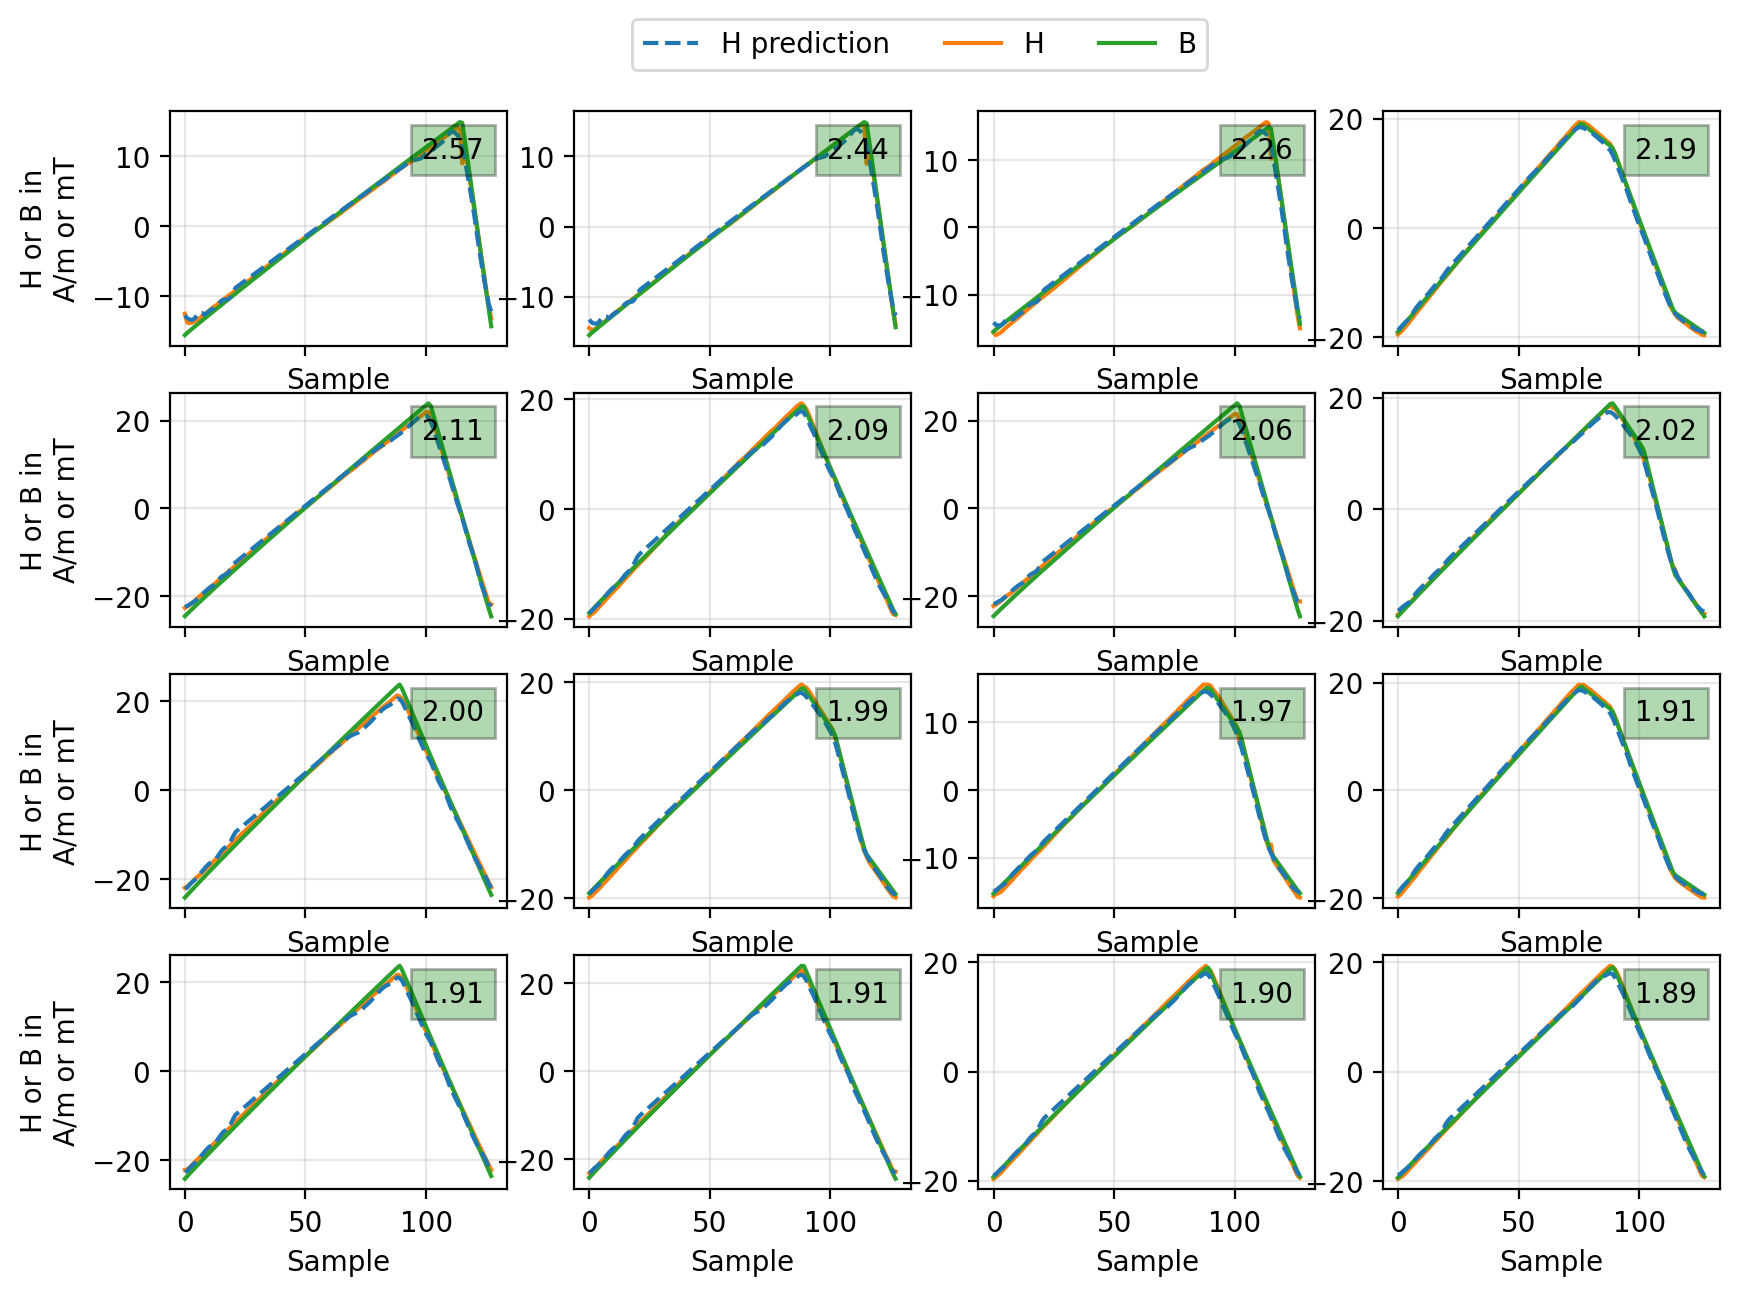

In [10]:
# top 5 worst-error profiles
fig, axes = plt.subplots(4, 4, figsize=(10, 7), sharex=True, sharey=False)
p = mat_df_proc.loc[:, 'ploss'].to_numpy()
rel_err = pd.Series(np.abs(p_pred.to_numpy() - p) / p, name='rel_err').sort_values(ascending=False)
for i, ax in enumerate(axes.flatten()):
        if ax in axes[:, 0]:
            ax.set_ylabel("H or B in\nA/m or mT")
        if j == n_sub_trajs-1:
            ax.set_xlabel("Sample")
        t_ind = rel_err.index[i]
        ln2 = ax.plot(mat_df_proc.loc[t_ind, H_COLS].to_numpy(), color="tab:orange", label="H", )
        ln3 = ax.plot(mat_df_proc.loc[t_ind, B_COLS].to_numpy()* 1000, color="tab:green", label="B")
        ln1 = ax.plot(h_pred[t_ind], color="tab:blue", label="H prediction", ls='dashed')
        lns = ln1 + ln2 + ln3
        legend_labels = [l.get_label() for l in lns]
        ax.text(0.75, 0.8, f"{np.abs(p_pred[t_ind]-p[t_ind])/ p[t_ind]:.2f}", transform=ax.transAxes, bbox=dict(facecolor='green', alpha=0.3))
        if i == 0:
            ax.legend(lns,legend_labels,ncol=3,frameon=True,markerscale=0.5,loc="lower center",bbox_to_anchor=(0.5, 0.9),bbox_transform=fig.transFigure,)

rel_err_gtruth = np.abs((p_derived - p))/p
print(pd.DataFrame({'rel_err_pred': rel_err, 'rel_err_gtruth': rel_err_gtruth[rel_err.index] }))

In [32]:
debug_df = pd.DataFrame({'b':mat_df_proc.loc[3971, B_COLS].to_numpy(),'h': mat_df_proc.loc[3971, H_COLS].to_numpy(), 'h_pred': h_pred[3971, :]})
debug_df


,b,h,h_pred
0,-0.015523,-12.475835,-12.695473
1,-0.015194,-13.744909,-13.127071
2,-0.014898,-13.804546,-13.278407
3,-0.014609,-13.731768,-13.369405
4,-0.014322,-13.544264,-13.146714
...,...,...,...
123,-0.004623,-4.425289,-5.452788
124,-0.007055,-6.794347,-7.516998
125,-0.009485,-9.191241,-9.373784
126,-0.011913,-11.458801,-11.080973


In [18]:
debug2_df = pd.DataFrame({'p_pred': p_pred, 'p_gtruth': p, 'p_derived': p_derived, 'rel_err_gtruth': rel_err_gtruth})
debug2_df.iloc[3971, :]

p_pred            5243.573789
p_gtruth          1469.036450
p_derived         1431.217658
rel_err_gtruth       0.025744
Name: 3971, dtype: float64

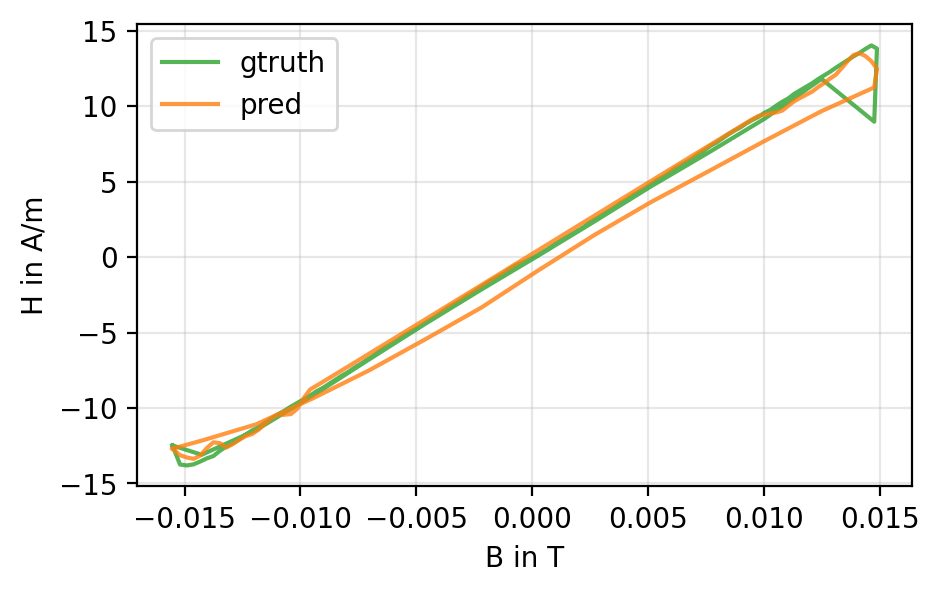

In [31]:
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
ax.plot((debug_df.b).tolist() + [debug_df.b.iloc[0]], debug_df.h.tolist() + [debug_df.h.iloc[0]], label='gtruth', alpha=.8, color='tab:green')
ax.plot((debug_df.b).tolist() + [debug_df.b.iloc[0]], debug_df.h_pred.tolist() + [debug_df.h_pred.iloc[0]], label='pred', alpha=.8, color='tab:orange')
ax.set_ylabel('H in A/m')
ax.set_xlabel('B in T')
ax.legend()

## Experiments with different normalizations (e.g., per-profile)

In [3]:
log_2 = main(ds=ds, per_profile_norm=True)

Train for 3F4
Parallelize over 1 seeds with 1 processes..


Seed 0, fold 0:   0%|          | 0/3000 [00:00<?, ?epoch/s]/home/wk/dev/tools/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
Seed 0, fold 0:   0%|          | 0/3000 [00:00<?, ?epoch/s]

Layer (type:depth-idx)                   Output Shape              Param #
TCNWithScalarsAsBias                     [1, 1, 128]               --
├─TemporalBlock: 1-1                     [1, 15, 128]              --
│    └─Sequential: 2-1                   [1, 15, 128]              --
│    │    └─Conv1d: 3-1                  [1, 15, 128]              570
│    │    └─Tanh: 3-2                    [1, 15, 128]              --
│    │    └─Dropout1d: 3-3               [1, 15, 128]              --
├─TemporalBlock: 1-2                     [1, 11, 128]              --
│    └─Sequential: 2-2                   [1, 11, 128]              --
│    │    └─Conv1d: 3-4                  [1, 11, 128]              143
│    │    └─Tanh: 3-5                    [1, 11, 128]              --
│    │    └─Dropout1d: 3-6               [1, 11, 128]              --
├─Sequential: 1-3                        [1, 1, 128]               --
│    └─TemporalBlock: 2-3                [1, 32, 128]              --
│    │    └─S

Seed 0, fold 0:  36%|███▋      | 1088/3000 [01:18<02:18, 13.81epoch/s, Loss 1.68e-04| val loss 1.63e-04]


KeyboardInterrupt: 

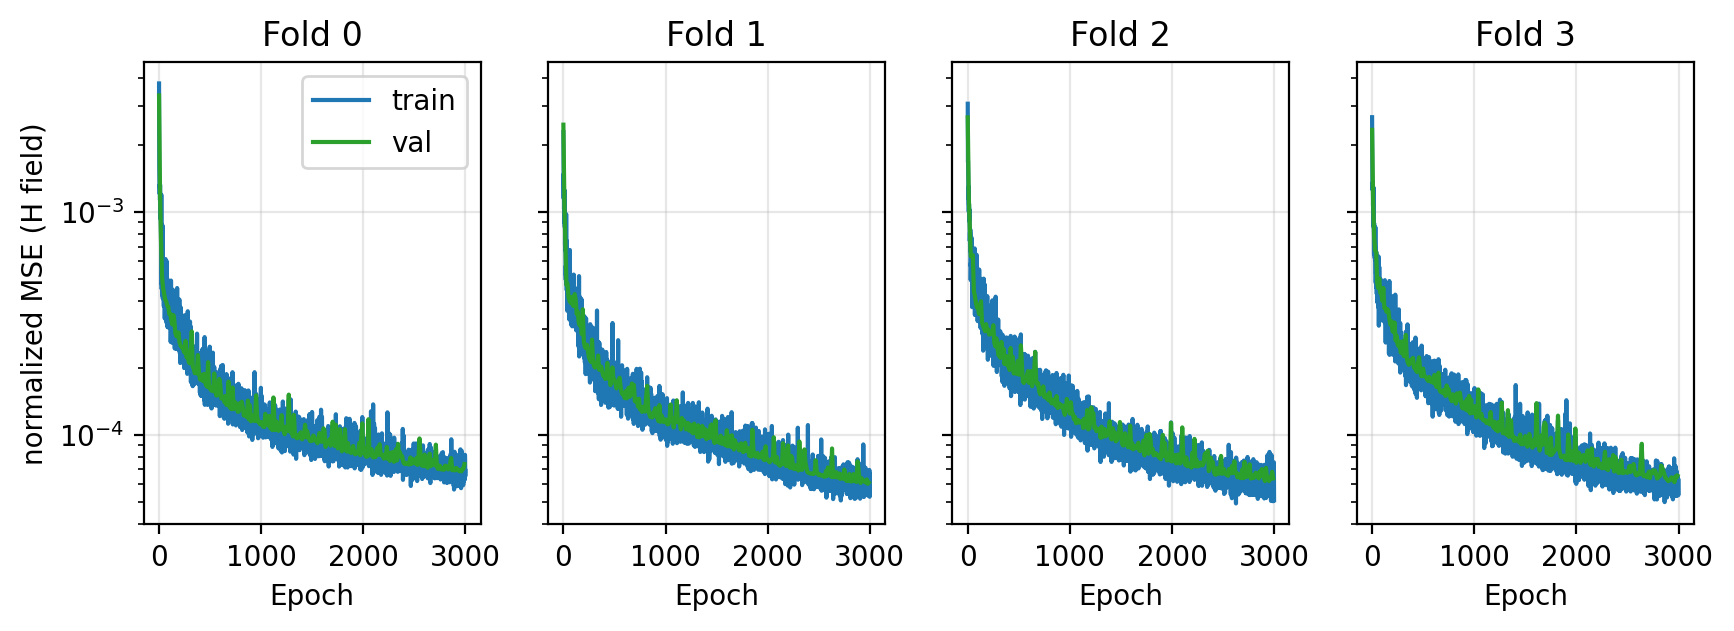

In [ ]:
fig, axes = plt.subplots(1, len(log_2['3F4'][0]['loss_trends_train']), sharey=True, sharex=True, figsize=(10,3))
for n, (fold_train, fold_val, ax) in enumerate(zip(log_2['3F4'][0]['loss_trends_train'], log_2['3F4'][0]['loss_trends_val'], axes)):
    ax.plot(fold_train, label='train' if ax is axes[0] else None, color='tab:blue')
    ax.plot(np.arange(len(fold_train))[::10],fold_val, label='val' if ax is axes[0] else None, color='tab:green')
    ax.set_title(f'Fold {n}')
    if n == 0:
        ax.set_ylabel('normalized MSE (H field)')
        ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_yscale('log')


In [ ]:
mat_df = ds
mat_df_proc = mat_df.assign(kfold=get_stratified_fold_indices(mat_df, 4))
mat_df_proc.drop(columns=["material"]).groupby('kfold').mean()

ploss      H_t_0      H_t_1      H_t_2      H_t_3      H_t_4  \
kfold                                                                         
0      234450.431189 -52.509797 -52.612627 -52.259090 -51.851729 -51.473718   
1      235442.150593 -52.375362 -52.456504 -52.099208 -51.650140 -51.223742   
2      239843.880792 -51.575139 -51.667113 -51.302248 -50.869942 -50.493127   
3      237585.406532 -52.855536 -52.956625 -52.589507 -52.170015 -51.786644   

           H_t_5      H_t_6      H_t_7      H_t_8      H_t_9     H_t_10  \
kfold                                                                     
0     -51.030404 -50.564112 -50.161126 -49.783917 -49.376153 -48.946204   
1     -50.773821 -50.328991 -49.917216 -49.519375 -49.110416 -48.661743   
2     -50.064976 -49.608625 -49.171400 -48.753727 -48.319359 -47.868341   
3     -51.378794 -50.934596 -50.510561 -50.091241 -49.657594 -49.198948   

          H_t_11     H_t_12     H_t_13     H_t_14     H_t_15     H_t_16  \
kfold                                                                     
0     -48.524708 -48.090871 -47.620312 -47.159422 -46.699824 -46.238758   
1     -48.215246 -47.762516 -47.286389 -46.823621 -46.356014 -45.879893   
2     -47.416216 -46.972997 -46.510599 -46.050663 -45.592339 -45.133215   
3     -48.733593 -48.281710 -47.811843 -47.352924 -46.898430 -46.441937   

          H_t_17     H_t_18     H_t_19     H_t_20     H_t_21     H_t_22  \
kfold                                                                     
0     -45.796980 -45.378347 -44.953262 -44.523299 -44.097225 -43.695129   
1     -45.433075 -45.003451 -44.575393 -44.138678 -43.706736 -43.302820   
2     -44.692332 -44.273386 -43.848745 -43.414999 -42.975015 -42.563534   
3     -46.004296 -45.579600 -45.156449 -44.721013 -44.288348 -43.880409   

          H_t_23     H_t_24     H_t_25     H_t_26     H_t_27     H_t_28  \
kfold                                                                     
0     -43.303310 -42.917360 -42.520569 -42.115334 -41.710267 -41.316695   
1     -42.910011 -42.509950 -42.093878 -41.677414 -41.262141 -40.857200   
2     -42.164173 -41.760937 -41.349545 -40.931891 -40.520272 -40.119083   
3     -43.489662 -43.090944 -42.683159 -42.269944 -41.847768 -41.453947   

          H_t_29     H_t_30     H_t_31     H_t_32     H_t_33     H_t_34  \
kfold                                                                     
0     -40.923008 -40.518757 -40.109608 -39.698215 -39.292458 -38.888286   
1     -40.454281 -40.040285 -39.619780 -39.201803 -38.786477 -38.373139   
2     -39.713689 -39.298098 -38.884277 -38.460085 -38.051118 -37.637088   
3     -41.059179 -40.652420 -40.240907 -39.820336 -39.394443 -38.985897   

          H_t_35     H_t_36     H_t_37     H_t_38     H_t_39     H_t_40  \
kfold                                                                     
0     -38.490925 -38.106614 -37.715574 -37.318008 -36.917557 -36.512307   
1     -37.970688 -37.570020 -37.169977 -36.764605 -36.356260 -35.934654   
2     -37.235036 -36.836425 -36.445102 -36.037633 -35.630135 -35.216580   
3     -38.581231 -38.183508 -37.782693 -37.384568 -36.974066 -36.565941   

          H_t_41     H_t_42     H_t_43     H_t_44     H_t_45     H_t_46  \
kfold                                                                     
0     -36.106208 -35.700763 -35.303644 -34.918611 -34.536983 -34.151392   
1     -35.525456 -35.109924 -34.706640 -34.309528 -33.911176 -33.517851   
2     -34.801075 -34.389998 -33.988013 -33.592397 -33.201427 -32.811435   
3     -36.150355 -35.742026 -35.348915 -34.949389 -34.563348 -34.176841   

          H_t_47     H_t_48     H_t_49     H_t_50     H_t_51     H_t_52  \
kfold                                                                     
0     -33.773810 -33.380564 -32.991943 -32.600911 -32.202987 -31.818884   
1     -33.129589 -32.727788 -32.331405 -31.933103 -31.536949 -31.145001   
2     -32.424854 -32.026750 -31.625585 -31.227351 -30.824946 -30.430426   
3     -3

In [ ]:
device = torch.device("cuda")
x_cols = [c for c in mat_df_proc if c not in ["ploss", "kfold"] and not c.startswith(("B_t_", "H_t_", "material"))]
b_limit = np.abs(mat_df_proc.loc[:, B_COLS].to_numpy()).max()
h_limit = np.abs(mat_df_proc.loc[:, H_COLS].to_numpy()).max()
b_limit_pp = np.abs(mat_df_proc.loc[:, B_COLS].to_numpy()).max(axis=1).reshape(-1,1)
h_limit = h_limit * b_limit_pp/b_limit
full_set = construct_tensor_seq2seq(mat_df_proc, x_cols, b_limit, h_limit, b_limit_pp=b_limit_pp).to(device)

mdl = log_2['3F4'][0]['models_state_dict'][0].to(device)
with torch.inference_mode():
    g_truth = full_set[:, :, [-1]]
    X_tensor = full_set[:, :, :-1]
    output = mdl(X_tensor.permute(1, 2, 0)).permute(2, 0, 1)

In [ ]:
h_pred = output.squeeze().cpu().numpy().T * h_limit
p_pred = get_bh_integral_from_two_mats(
    freq=mat_df_proc.freq, #np.exp(full_set.cpu().numpy()[0, :, [0]]) * 150_000,
    b=mat_df_proc.loc[:, B_COLS],#full_set.cpu().numpy()[:, :, -2].T * b_limit,
    h=h_pred,
)
calculate_metrics(p_pred, mat_df_proc.loc[:, 'ploss'])

{'mse': 404721403.73534846,
 'mae': 9233.553388173521,
 'avg-abs-rel-err': 0.06947612527246268,
 'percentile_5_rel_err': 0.005463616728304913,
 'percentile_95_rel_err': 0.17071402629458338,
 'l_infty': 228111.92708028737,
 'l_infty_over': 162577.78908876237,
 'l_infty_under': -228111.92708028737}

/tmp/ipykernel_22504/1073731052.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


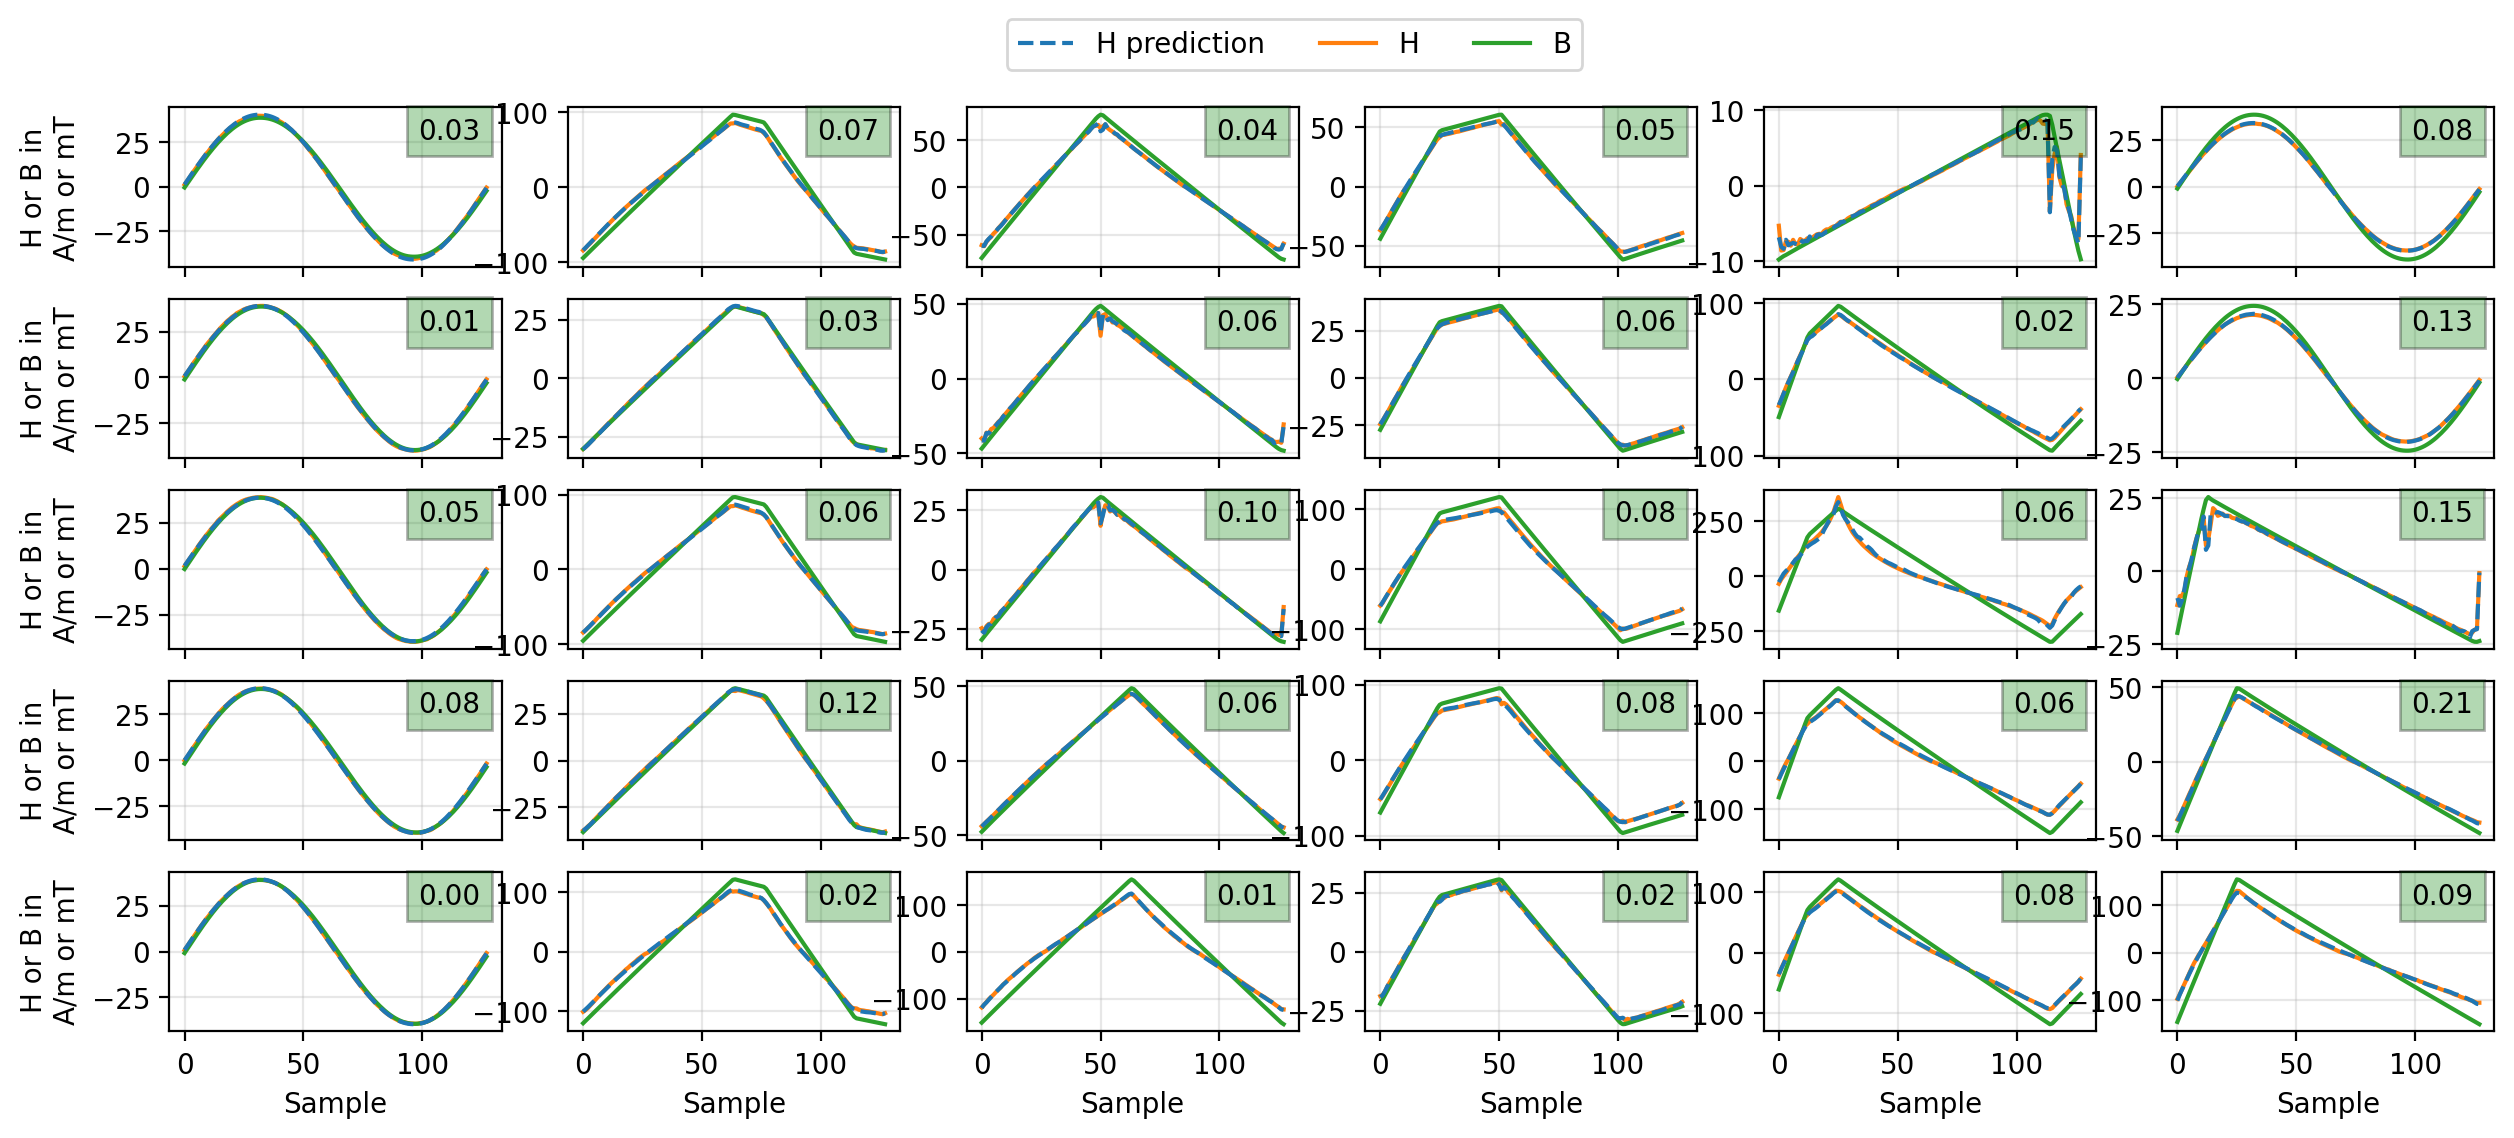

In [ ]:
tois = np.arange(0, 6000, 1000)  # trajectory of interest
n_sub_trajs = 5
full_h = mat_df_proc.loc[:, H_COLS]
fig, axes = plt.subplots(n_sub_trajs,len(tois), figsize=(15, 6), sharex=True, sharey=False)
for i, toi in enumerate(tois):
    for j in range(n_sub_trajs):  # subvariations
        t_ind = toi + j * 5
        h = full_h.loc[t_ind, :].to_numpy()  # in A/m
        p = mat_df_proc.loc[t_ind, 'ploss']
        ax = axes[j, i]
        if i == 0:
            ax.set_ylabel("H or B in\nA/m or mT")
        if j == n_sub_trajs-1:
            ax.set_xlabel("Sample")
        ln2 = ax.plot(h, color="tab:orange", label="H", )
        ln3 = ax.plot(mat_df_proc.loc[t_ind, B_COLS].to_numpy()* 1000, color="tab:green", label="B")
        ax.text(0.75, 0.8, f"{np.abs(p_pred[t_ind]-p)/ p:.2f}", transform=ax.transAxes, bbox=dict(facecolor='green', alpha=0.3))
        ln1 = ax.plot(h_pred[t_ind], color="tab:blue", label="H prediction", ls='dashed')
        lns = ln1 + ln2 + ln3
        legend_labels = [l.get_label() for l in lns]
        if i == 0 and j == 0:
            ax.legend(lns,legend_labels,ncol=3,frameon=True,markerscale=0.5,loc="lower center",bbox_to_anchor=(0.5, 0.9),bbox_transform=fig.transFigure,)
fig.tight_layout()

In [ ]:
p_derived = get_bh_integral_from_two_mats(freq=mat_df_proc.freq, b=mat_df_proc.loc[:, B_COLS], h=mat_df_proc.loc[:, H_COLS])
calculate_metrics(p_derived, mat_df_proc.loc[:, 'ploss'])

{'mse': 38992979.205653675,
 'mae': 3913.3350232703256,
 'avg-abs-rel-err': 0.042169654629524,
 'percentile_5_rel_err': 0.007061112434444114,
 'percentile_95_rel_err': 0.10347815880963578,
 'l_infty': 42410.45597695047,
 'l_infty_over': 9931.942968738018,
 'l_infty_under': -42410.45597695047}

      rel_err_pred  rel_err_gtruth
6557      0.450121        0.290010
6558      0.441751        0.255391
3990      0.439071        0.534504
3991      0.394159        0.495156
3964      0.378259        0.071892
...            ...             ...
1061      0.000089        0.009517
1941      0.000080        0.014316
6275      0.000065        0.039694
3012      0.000055        0.042572
3396      0.000049        0.057244

[6563 rows x 2 columns]


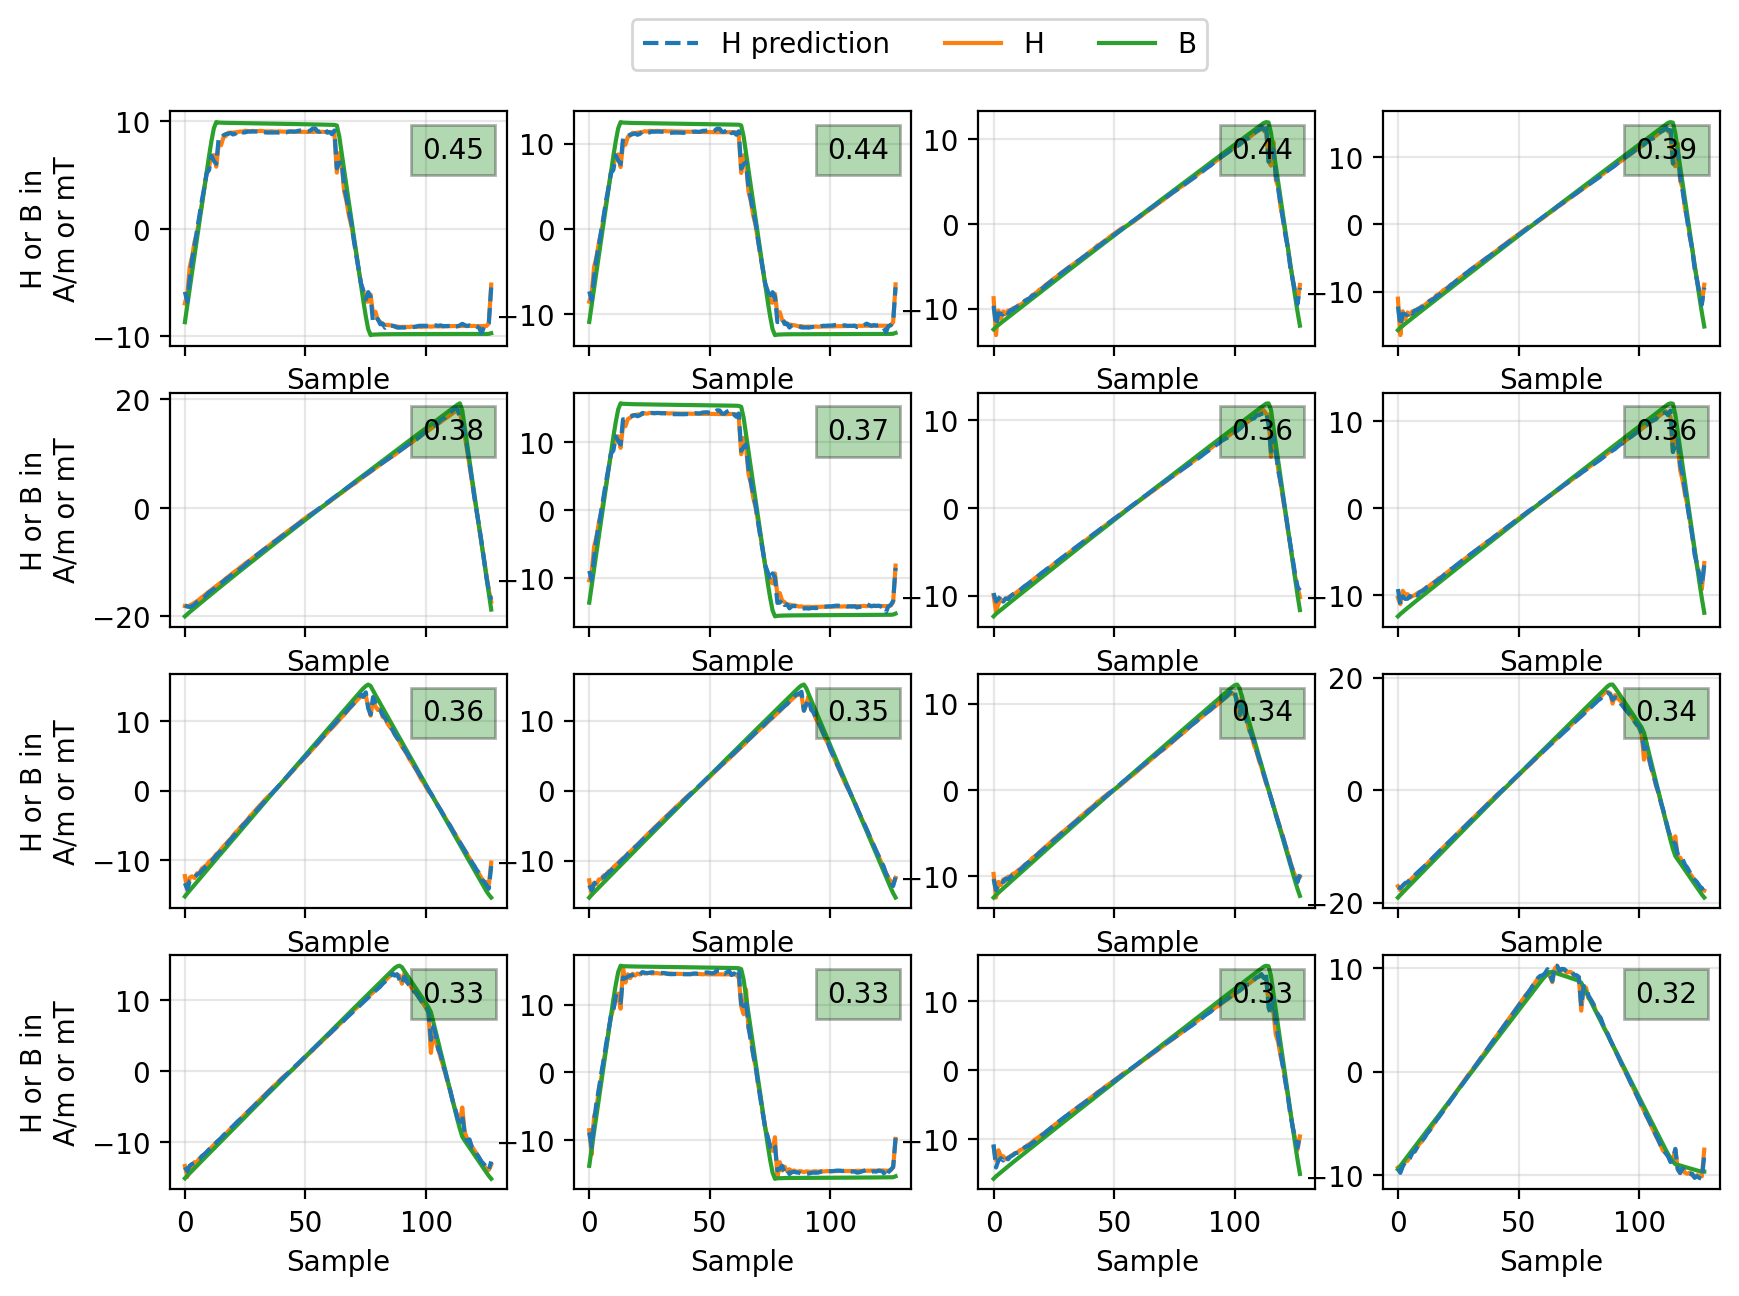

In [ ]:
# top 5 worst-error profiles
fig, axes = plt.subplots(4, 4, figsize=(10, 7), sharex=True, sharey=False)
p = mat_df_proc.loc[:, 'ploss'].to_numpy()
rel_err = pd.Series(np.abs(p_pred.to_numpy() - p) / p, name='rel_err').sort_values(ascending=False)
for i, ax in enumerate(axes.flatten()):
        if ax in axes[:, 0]:
            ax.set_ylabel("H or B in\nA/m or mT")
        if j == n_sub_trajs-1:
            ax.set_xlabel("Sample")
        t_ind = rel_err.index[i]
        ln2 = ax.plot(mat_df_proc.loc[t_ind, H_COLS].to_numpy(), color="tab:orange", label="H", )
        ln3 = ax.plot(mat_df_proc.loc[t_ind, B_COLS].to_numpy()* 1000, color="tab:green", label="B")
        ln1 = ax.plot(h_pred[t_ind], color="tab:blue", label="H prediction", ls='dashed')
        lns = ln1 + ln2 + ln3
        legend_labels = [l.get_label() for l in lns]
        ax.text(0.75, 0.8, f"{np.abs(p_pred[t_ind]-p[t_ind])/ p[t_ind]:.2f}", transform=ax.transAxes, bbox=dict(facecolor='green', alpha=0.3))
        if i == 0:
            ax.legend(lns,legend_labels,ncol=3,frameon=True,markerscale=0.5,loc="lower center",bbox_to_anchor=(0.5, 0.9),bbox_transform=fig.transFigure,)

rel_err_gtruth = np.abs((p_derived - p))/p
print(pd.DataFrame({'rel_err_pred': rel_err, 'rel_err_gtruth': rel_err_gtruth[rel_err.index] }))